<a href="https://colab.research.google.com/github/Mayvei64/Piramida/blob/main/ML_Lab%E2%84%962/Classification_by_Usyninprog_Sample%E2%84%962.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

Для выполнения лабрторной работы 2 выбрали датасет mobile.csv, содеражащий данные о продажах смартфонов различных категорий( 0 - низкая цена, 1 - средняя цена, 2 - высокая цена, 3 - очень высокая цена).

Данные представляют из себя таблицы с названиями колонок: battery_power – объем аккумулятора (мАч)

blue – наличие поддержки Bluetooth

clock_speed – частота процессора (ГГц)

dual_sim – наличие поддержки двух SIM-карта

fc – количество мегапикселей фронтальной камеры

four_g – наличие поддержки 4G

int_memory – объем внутренней памяти (ГБ)

m_dep – толщина мобильного телефона (см)

mobile_wt –вес мобильного телефона (г)

n_cores – количество ядер процессора

pc – количество мегапикселей основной (задней)камеры

px_height – разрешение экрана по высоте (пиксели)

px_width – разрешение экрана поширине (пиксели)

ram – объем оперативной памяти (МБ)

sc_h – высота экрана (см)

sc_w – ширина экрана (см)

talk_time – максимальноевремяработыотзарядааккумулятораврежимеожидания

three_g – наличие поддержки 3G

touch_screen – наличиесенсорногоэкрана

wifi – наличие поддержки Wi-Fi

price_range – ценовая категория (0 – низкая стоимость, 1 – средняя стоимость, 2 – высокая стоимость, 3 – очень высокая стоимость) – целевой признак

Задача:Классифицировать телефоны по ценам

In [ ]:
df_mobile = pd.read_csv('mobile.csv')
df_mobile.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [ ]:
'''
Определяет, является ли столбец числовым или категориальным.
:параметр
     :param dtf: dataframe - входные данные
     :param col:str - имя столбца для анализа
     :param max_cat: num — максимальное количество уникальных значений для распознавания столбца как категориального
:возвращает
     "cat", если столбец является категориальным или "num" в противном случае
'''
def utils_recognize_type(df_mobile, col, max_cat=21):
    if (df_mobile[col].dtype == "O") | (df_mobile[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

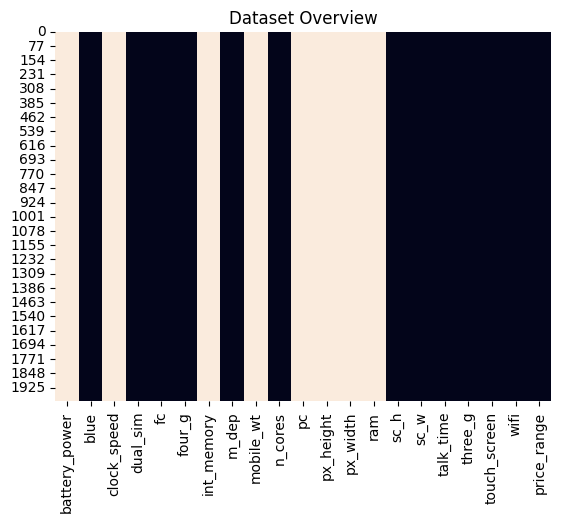

 Categerocial   Numeric   NaN 


In [ ]:
'''
формируем словарь dic_cols.
Ключи - название фич
Значение - категориальный (cat) или числовой (num)
'''
dic_cols = {col:utils_recognize_type(df_mobile, col, max_cat=21) for col in df_mobile.columns}

'''
dtf.isnull() - возвращает датасет, который похож на изначальный датасет dtf, но в каждой ячейке вместо значений написано:
 False (если значение есть)
 True  (если в ячейке отсутствует значение)
'''
heatmap = df_mobile.isnull()

'''
А дальше проходим по столбцам, и меняем значения:
 если столбец числовой:
    пишем 0.5, если значение False (то есть оно не нулевое)
    пишем 1,   если значение True

 если столбец категориальный
    пишем 0, если значение False   (то есть оно не нулевое)
    пишем 1,   если значение True

После этого у нас окажется, что значения могут принимать всего три различных значения.
'''
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

'''
Строим heatmap (тепловую карту)
0.5 - если значение есть и оно числовое
0   - если значение есть и оно категориальное
1   - если значения в ячейке нет
'''
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')

plt.show()

'''
Печатаем внизу подобие легенды, раскрашивая так, как нужно.
'''
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

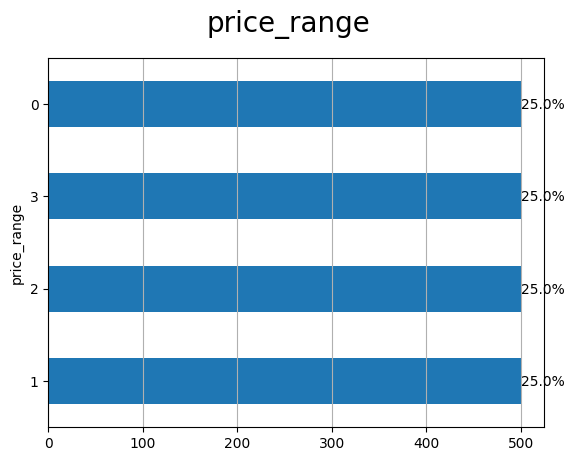

In [ ]:
'''
группируем все объекты по их целевой переменной (species) и просто считаем, сколько объектов попало в каждую группу
'''

# вот тут задаем название столбца, по значению в котором и будем группировать
y ="price_range"
'''
далее считаем количество объектов с одинаковыми значениями в столбце y: dtf[y].value_counts()
потом сортируем полученное sort_values()
и задаем plot
'''
ax = df_mobile[y].value_counts().sort_values().plot(kind="barh")

'''
Затем занимаемся тем, что формируем надписи для графика
'''
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
            str(round((i.get_width()/total)*100, 2))+'%',
            fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)

'''
И наконец-то отрисовываем
'''
plt.show()

In [ ]:
df_mobile['price_range'].value_counts()

,count
price_range,
1,500
2,500
3,500
0,500


In [ ]:

x = "price_range"
def show_dist(x, df_mobile):
    '''
    :param x: название столбца
    :param dtf: датасет
    :return: ничего не возвращает
    '''
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15, 10))
    fig.suptitle(x, fontsize=20)
    ### distribution
    ax[0].title.set_text('distribution')
    variable = df_mobile[x].fillna(df_mobile[x].mean())
    breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
    variable = variable[(variable > breaks[0]) & (variable <
                                                  breaks[10])]
    sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
                 ax=ax[0])  #Запишем чтобы создать горизонтальную гистограмму
    des = df_mobile[x].describe()


    '''
    Добавим квантильные и средние линии
     '''
    ax[0].axvline(des["25%"], ls='--')
    ax[0].axvline(des["mean"], ls='--')
    ax[0].axvline(des["75%"], ls='--')
    ax[0].grid(True)
    des = round(des, 2).apply(lambda x: str(x))
    box = '\n'.join(
        ("min: " + des["min"], "25%: " + des["25%"], "mean: " + des["mean"], "75%: " + des["75%"], "max: " + des["max"]))
    ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right",
               bbox=dict(boxstyle='round', facecolor='white', alpha=1))
    '''
     Формируем надписи для графика
    '''
    ### boxplot
    ax[1].title.set_text('outliers (log scale)')  #устанавливаем заголовок
    tmp_dtf = pd.DataFrame(df_mobile[x])
    tmp_dtf[x] = np.log(tmp_dtf[x])
    tmp_dtf.boxplot(column=x, ax=ax[1])
    '''
    Отрисовываем
    '''
    plt.show()


<ipython-input-50-c814ffecaf34>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


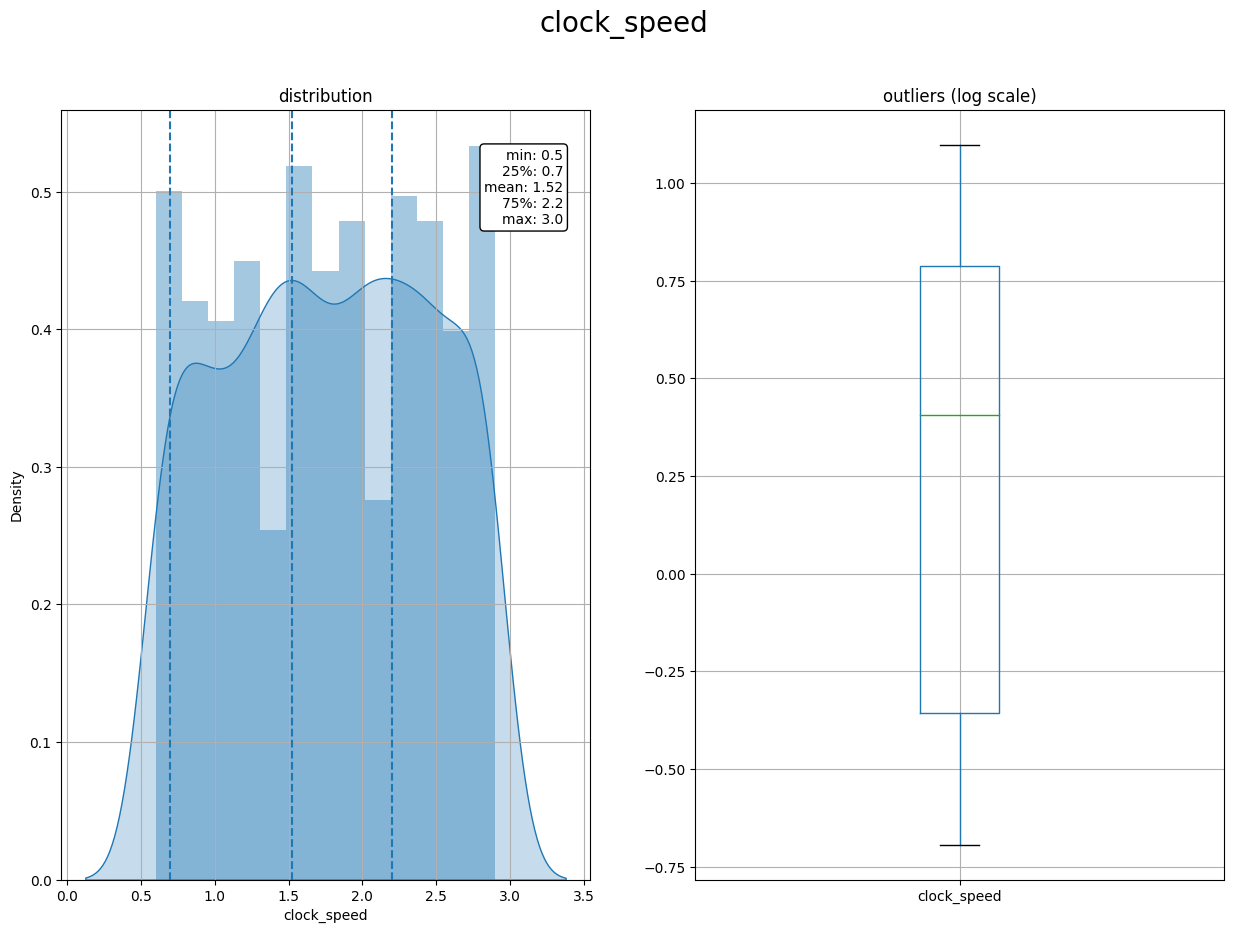

In [ ]:
show_dist('clock_speed', df_mobile)

<ipython-input-44-1fdcf3bbced1>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


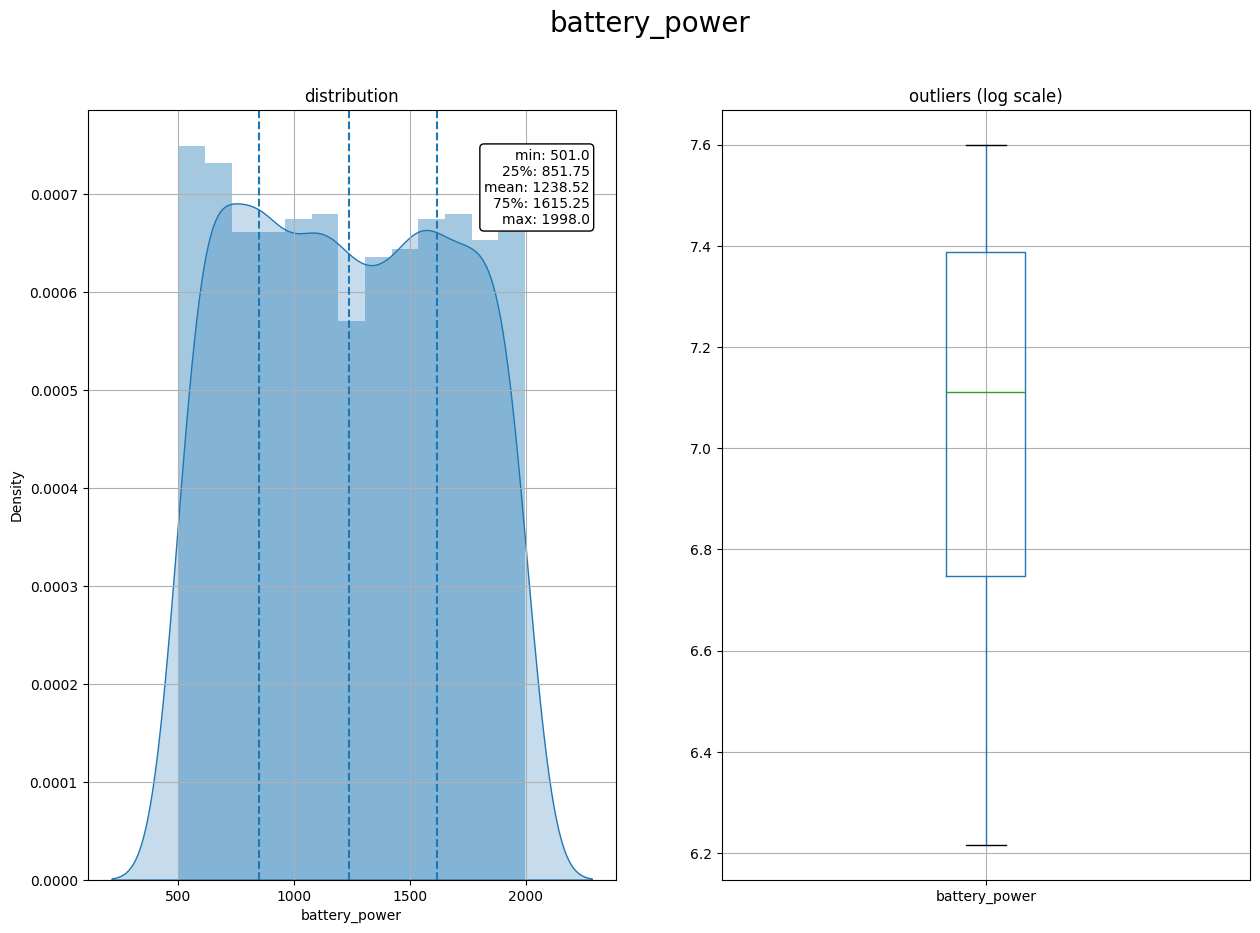

In [ ]:
show_dist('battery_power', df_mobile)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


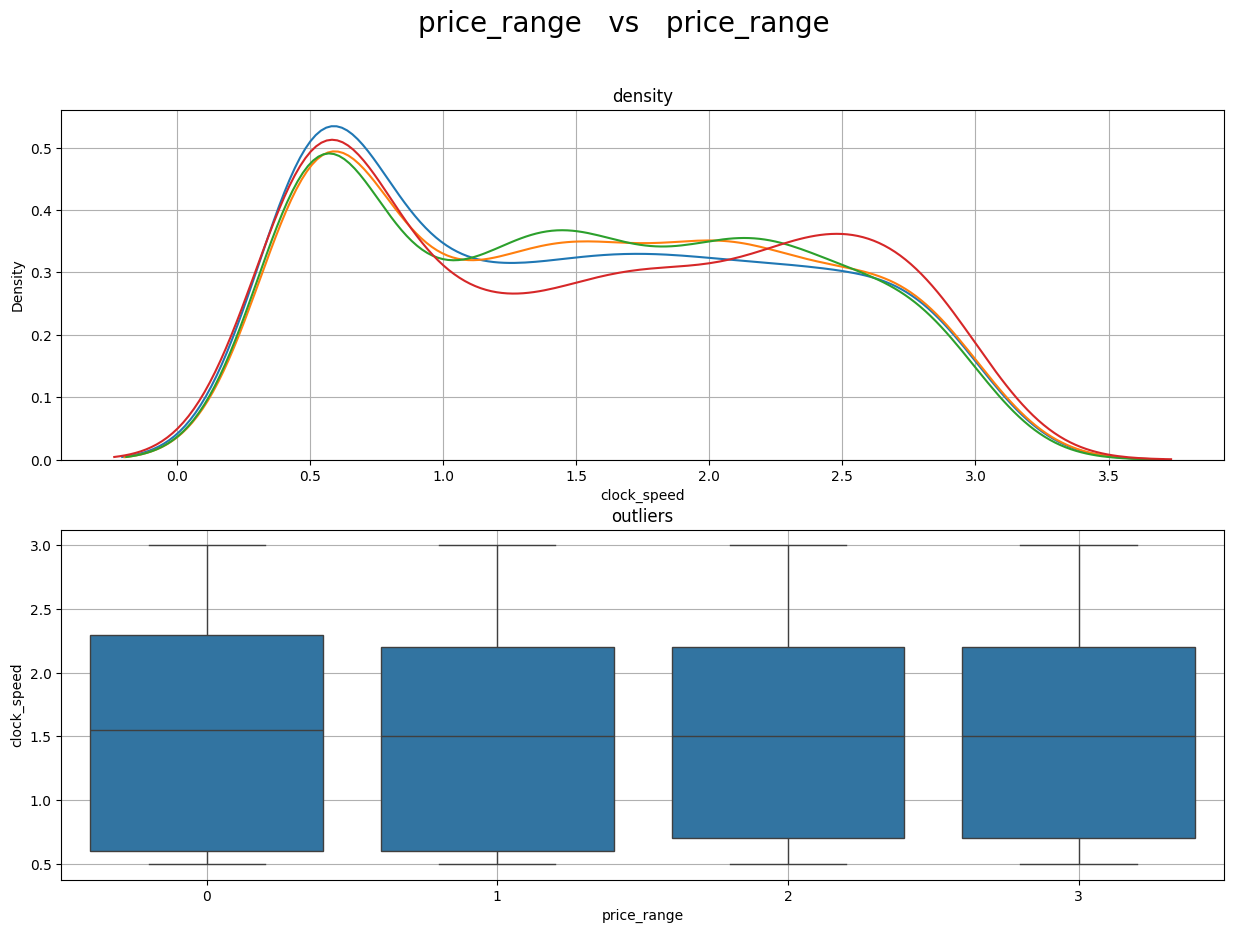

In [ ]:
'''
Для того, чтобы понять, обладает ли  "body_mass_g" предсказательной силой для предсказания"species", построим график плотности распределений и усиковую диаграмму body_mass_g  для каждого уникального species.

'''

cat, num = "price_range", "clock_speed"
fig, ax = plt.subplots(nrows=2, ncols=1,  sharex=False, sharey=False, figsize=(15, 10))# распаковываем  кортеж в переменные figи ax.
fig.suptitle(x+"   vs   "+y, fontsize=20)# получаем объект рисунка и массив подграфиков,где первое число - количество строк,второе - столбцов, sharex, sharey задают нужно ли разделять ось между подграфиками
'''
Пропишем распределение:
'''

### distribution
ax[0].title.set_text('density')
for i in df_mobile[cat].unique():  # перебираем все уникальные значения в столбце dtf[cat], cat="species"
    sns.kdeplot(df_mobile[df_mobile[cat]==i][num],   label=i, ax=ax[0])#Построим график плотности распределения в столбце num, при условии, что значение в столбце dtf[cat] совпадет с i
ax[0].grid(True)#Настроим линии сетки.

### boxplot
ax[1].title.set_text('outliers')#устанавливаем заголовок
sns.boxplot(x=cat, y=num, data=df_mobile, ax=ax[1])#Нарисуем блочную диаграмму, чтобы показать распределения по категориям.


ax[1].grid(True)#Настроим линии сетки.
'''
  Отрисовываем
'''

plt.show()

Делим на тренировочную выборку и тестовую

In [ ]:
dtf_train, dtf_test = model_selection.train_test_split(df_mobile, test_size=0.3)
train_x = dtf_train.drop(['price_range'],axis=1)
train_y = dtf_train['price_range']
test_x = dtf_test.drop(['price_range'],axis=1)
test_y = dtf_test['price_range']

In [ ]:

# нормируем значения
Y = df_mobile['price_range']

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))#приведем Числовые переменные (Numeric Variable) к диапазону от 0 до 1.
X = scaler.fit_transform(train_x)#преобразуем данные таким образом, что их распределение будет иметь среднее значение 0 и стандартное отклонение 1.
'''
 X_train - это весь экземпляр с атрибутами,
 y_train - это метка каждого экземпляра.
'''
train_x_scaled = pd.DataFrame(X, columns=train_x.columns,index=train_x.index )
train_y_scaled = train_y

train_x_scaled.head()# выводим



,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
862,0.376754,1.0,0.00,0.0,0.000000,1.0,0.193548,0.666667,0.075000,0.142857,0.10,0.095918,0.285714,0.754142,0.357143,0.055556,0.888889,1.0,0.0,1.0
1146,0.949900,0.0,0.20,1.0,0.263158,1.0,0.193548,0.888889,0.616667,0.428571,0.30,0.007653,0.016689,0.604757,0.571429,0.000000,0.777778,1.0,0.0,1.0
695,0.039412,1.0,0.60,1.0,0.315789,1.0,0.887097,0.222222,0.008333,0.285714,0.60,0.040816,0.552069,0.510689,0.428571,0.555556,0.277778,1.0,0.0,1.0
509,0.915832,1.0,0.72,0.0,0.315789,0.0,0.677419,0.666667,0.450000,0.285714,0.75,0.234184,0.506676,0.454035,0.285714,0.222222,0.722222,1.0,0.0,1.0
900,0.336673,0.0,0.00,0.0,0.000000,0.0,0.709677,0.333333,0.441667,1.000000,0.85,0.089796,0.704940,0.969535,0.857143,0.000000,1.000000,0.0,1.0,1.0


<ipython-input-6-1fdcf3bbced1>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


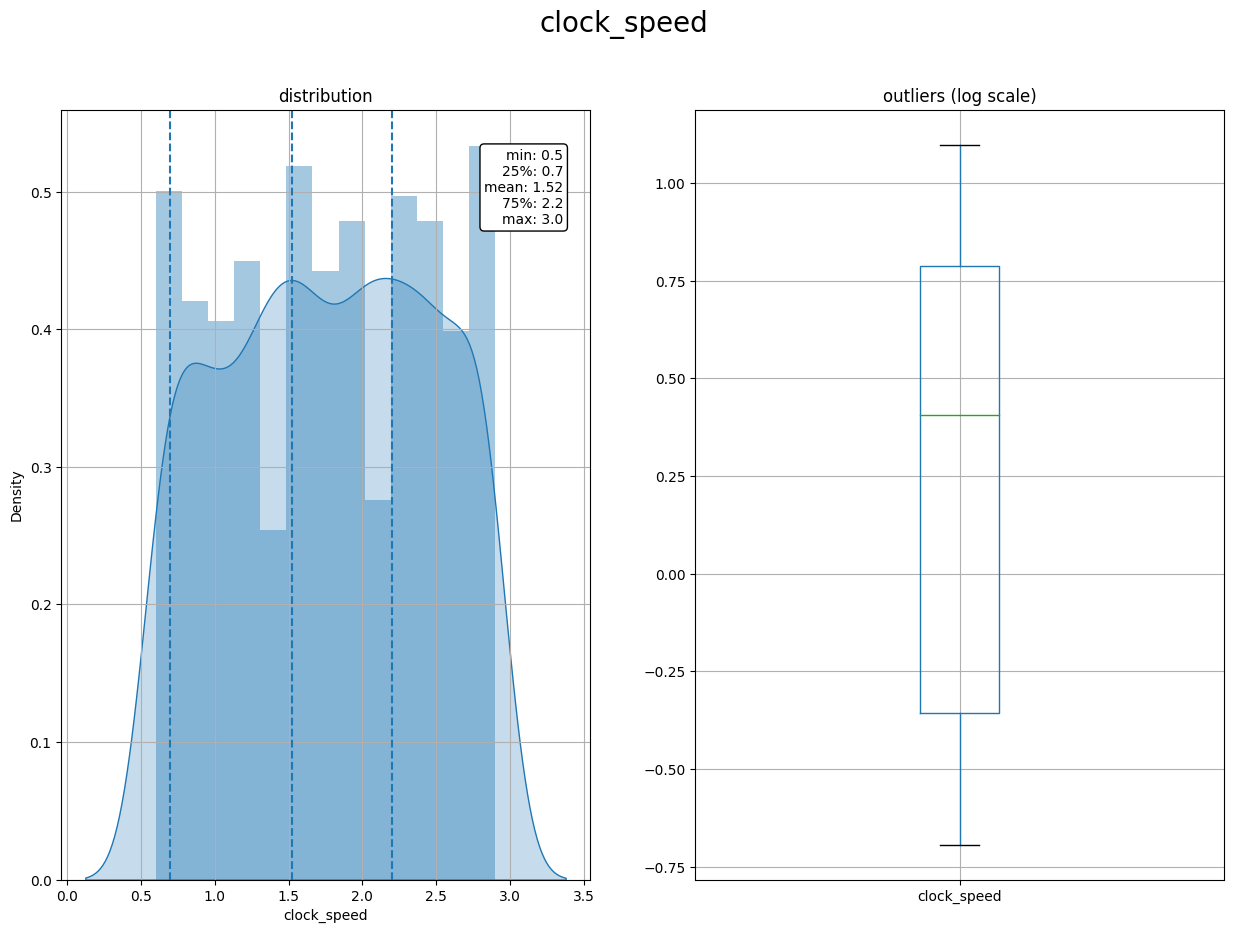

In [ ]:
show_dist('clock_speed', df_mobile) #используем ранее созданную нами функцию для отрисовки графиков

<ipython-input-6-1fdcf3bbced1>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


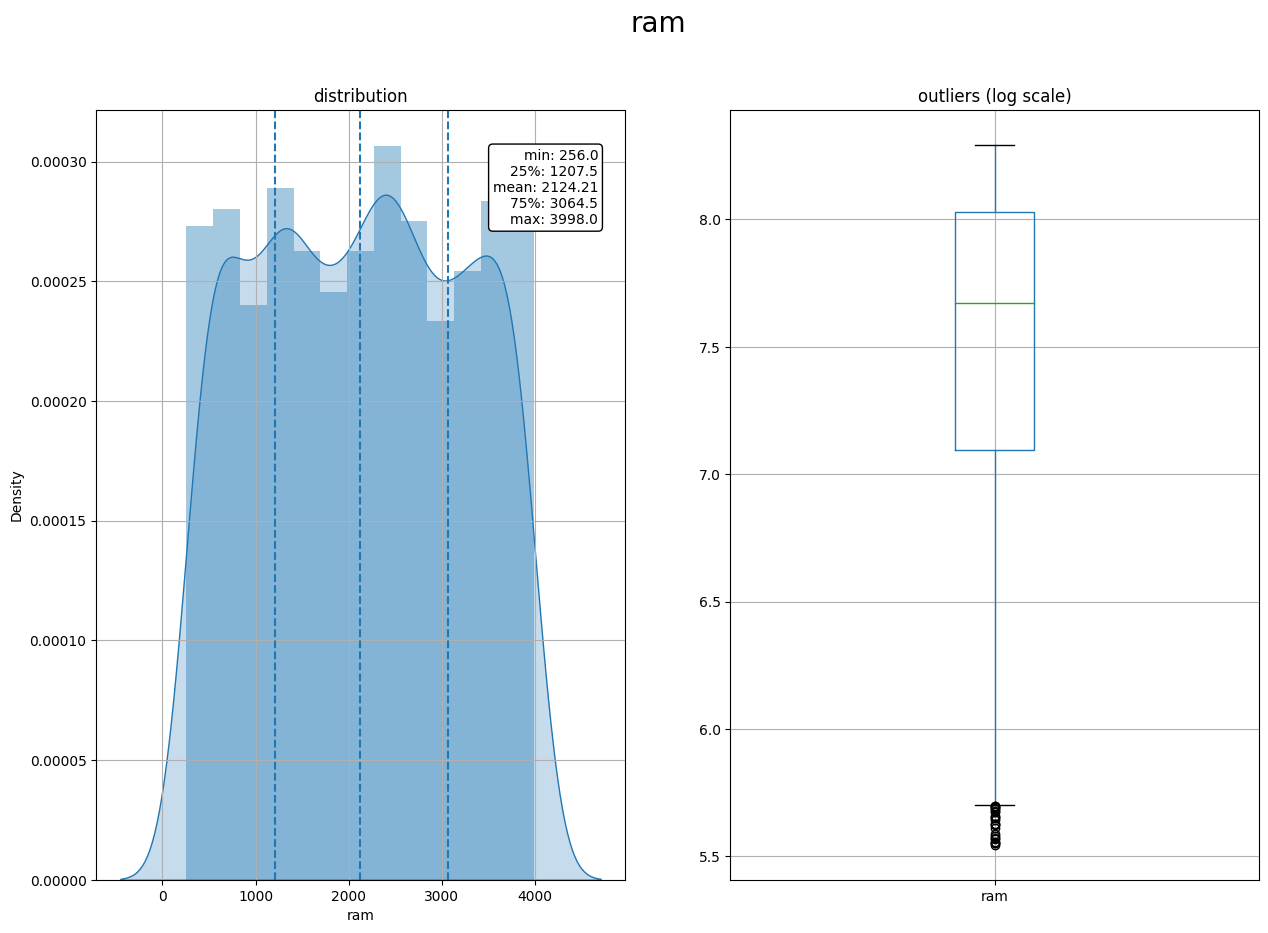

In [ ]:
show_dist('ram', df_mobile) #используем ранее созданную нами функцию для отрисовки графиков

In [ ]:
'''
Смотрим, что лежит в X, который результат нормировки train_x
'''
X

array([[0.17056856, 0.        , 0.72      , ..., 1.        , 0.        ,
        1.        ],
       [0.86287625, 1.        , 0.2       , ..., 1.        , 0.        ,
        1.        ],
       [0.19464883, 1.        , 0.92      , ..., 1.        , 1.        ,
        0.        ],
       ...,
       [0.03879599, 0.        , 0.        , ..., 0.        , 1.        ,
        1.        ],
       [0.93578595, 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.16789298, 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
'''
смотрим какие индексы (по-сути номера объектов в основном датасете) остались в трейне
'''
train_x.index

Index([ 851, 1848, 1796,  723, 1188, 1861, 1308, 1324, 1465, 1584,
       ...
        351, 1875, 1595,  836,    9, 1236,  302,  387, 1314, 1735],
      dtype='int64', length=1400)

In [ ]:
'''
Метод fit(data) используется для вычисления среднего значения и стандартного отклонения для данной функции, которые будут использоваться в дальнейшем для масштабирования.
Метод transform(data) используется для выполнения масштабирования с использованием среднего значения и стандартного отклонения, рассчитанного с использованием метода .fit().
Метод fit_transform() выполняет как подгонку, так и преобразование.
 X_train - это весь экземпляр с атрибутами,
 y_train - это метка каждого экземпляра.
scaled_x_train - фрейм данных с именами объектов,
scaled_x_test.values - значения, без имен объектов
 '''
X = scaler.fit_transform(test_x)

test_x_scaled = pd.DataFrame(X, columns=test_x.columns,index=test_x.index )
test_y_scaled = test_y

Поймём какие фичи данных наиболее значимы для классификации, и предоставим визуальное представление о распределении важности фичей.

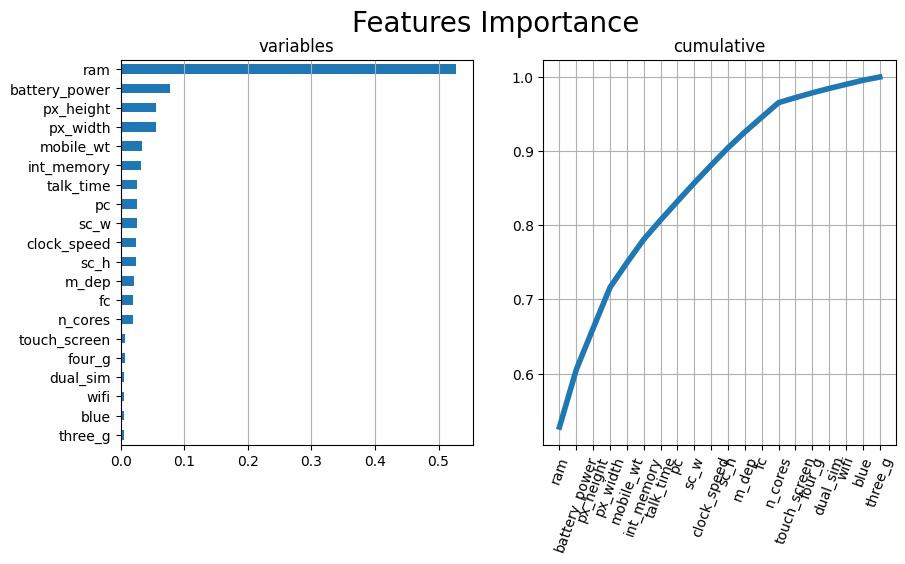

In [ ]:
'''
Оцениваем важность каждой фичи c помощью RandomForestClassifier

'''
X = train_x_scaled.values
y = train_y_scaled.values
feature_names = train_x_scaled.columns.tolist()# имена столбцов в data.
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_ #это оценка, присваиваемая функциям модели машинного обучения,которая определяет, насколько «важной» является функция для прогноза модели.
## Создаем датафрейм с оценками важности фичей:
dtf_importances = pd.DataFrame({"IMPORTANCE":importances,
                                "VARIABLE":feature_names}).sort_values("IMPORTANCE",
                                                                       ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")


## Plot
'''
 Формируем надписи для графика

 ticks : подобный массиву, содержащий список местоположений xtick. Передача пустого списка удаляет все xticks. (По желанию)
labels : подобный массиву, содержащий метки для размещения в заданных местах тиков. Этот аргумент может быть передан только в том случае, если также переданы тики. (По желанию)
kwargs : текстовые свойства, которые можно использовать для управления внешним видом меток.
Функция Matplotlib xticks() возвращает:
locs: список местоположений xtick.
labels: список текстовых объектов xlabel
plt.grid - Настройка линий сетки.
axis - Ось, к которой применяются изменения.


'''
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(10,5),dpi=100)# распаковываем  кортеж в переменные figи ax.
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')# подпишем график
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')# подпишем график
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')#Настроим линии сетки.
'''
Отрисовываем
'''
plt.show()

In [ ]:
'''
Проектирование, обучение, тестирование и оценка модели машинного обучения:
'''
X_train = train_x_scaled[['ram', 'battery_power', 'px_height', 'px_width']]
y_train = train_y_scaled

X_test = test_x_scaled[['ram', 'battery_power', 'px_height', 'px_width']]
y_test = test_y_scaled

In [ ]:
'''
Будем использовать GradientBoostingClassifier - градиентный бустинг. Он строит предсказание в виде ансамбля слабых предсказывающих моделей, которыми в основном являются деревья решений. Из нескольких слабых моделей в итоге мы собираем одну, но уже эффективную. Общая идея алгоритма – последовательное применение предиктора (предсказателя) таким образом, что каждая последующая модель сводит ошибку предыдущей к минимуму.
 Оценивать качество предсказаний будем по RandomizedSearchCV
'''

## call model
model = ensemble.GradientBoostingClassifier()
## define hyperparameters combinations to try
param_dic = {'learning_rate':[0.15,0.1,0.05],     #весовой коэффициент для поправок по новым деревьям при добавлении в модель
             'n_estimators':[100,250,500],  #количество деревьев, добавленных в модель
             'max_depth':[2,3,4,5],    #максимальная глубина дерева
             'min_samples_split':[2,4,6],    #задает минимальное количество выборок для разделения
             'min_samples_leaf':[1,3,5],     #минимальное количество выборок для формирования листа
             'max_features':[2,3,4],     #квадратный корень из функций обычно является хорошей отправной точкой
             'subsample':[0.7,0.8,0.9,1]}       #образцы, которые будут использоваться для подгонки индивидуального базового файла
## random search(Рандомизированный поиск по гиперпараметрам.)
random_search = model_selection.RandomizedSearchCV(model,
                                                   param_distributions=param_dic, n_iter=10,
                                                   scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_   # здесь теперь хранятся параметры, при которых были получены наилучшие метрики на трейне

Best Model parameters: {'subsample': 0.7, 'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 2, 'max_depth': 3, 'learning_rate': 0.05}
Best Model mean accuracy: 0.9157142857142857


In [ ]:

## заполняем модель данным из трайн датасетов
model.fit(X_train, y_train)
## test
predicted_prob = model.predict_proba(X_test) #генерирует вектора вероятностей для каждого тестового экземпляра.

'''

'''
predicted = model.predict(X_test).astype('int32') #возвращает предсказанные классы, которые затем приводятся к целочисленному типу данных

In [ ]:
# а это истинное значение, кто к какому классу относится
y_test.astype('int32') #astype -  позволяет преобразовывать тип данных существующего столбца данных в набор данны

,price_range
1872,1
284,2
1348,0
1074,1
1597,0
...,...
570,3
1072,3
1611,2
1430,1


In [ ]:
## Accuray e AUC
'''
Теперь смотрим метрики.
НА ТЕСТОВОМ ДАТАСЕТЕ
'''
accuracy = metrics.accuracy_score(y_test, predicted)#Оценим точность классификации.

auc = metrics.roc_auc_score(y_test, predicted_prob,  multi_class='ovo',average= "weighted") #возвращаем долю правильно классифицированных выборок.
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
'''
Получим результат
'''

## Precision e Recall
recall = metrics.recall_score(y_test, predicted, average="weighted")
precision = metrics.precision_score(y_test, predicted, average="weighted")
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.91
Auc: 0.99
Recall (all 1s predicted right): 0.91
Precision (confidence when predicting a 1): 0.91
Detail:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       151
           1       0.88      0.90      0.89       150
           2       0.91      0.88      0.89       153
           3       0.93      0.94      0.93       146

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600



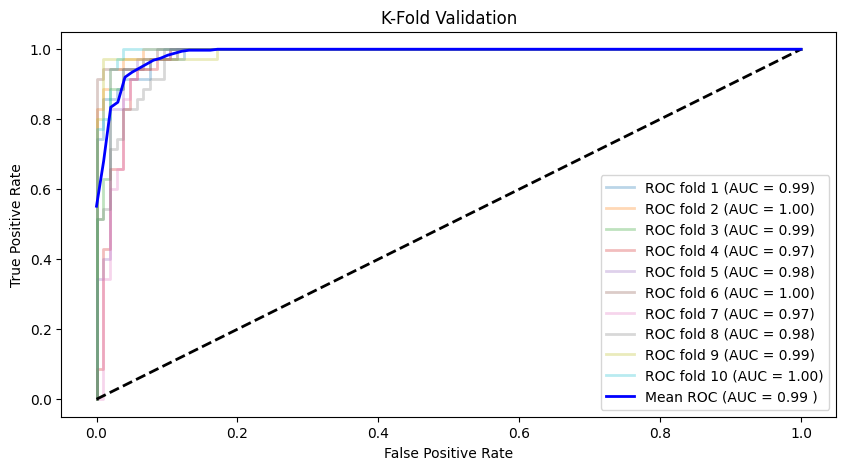

In [ ]:
'''
Строим ROC кривые
'''
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure(figsize=(10,5),dpi=100)
i = 1
for train, test in cv.split(X_train, y_train):
    '''
iloc - позволяет получить определенное значение, принадлежащее к строке и столбцу,
используя указанные значения индекса
X_train - это весь экземпляр с атрибутами,
y_train - это метка каждого экземпляра.
train_selected_test - Разделяет массивы / матрицы на случайные тестовые подмножества.

'''
    X_train_selected = X_train.iloc[train]

    y_train_selected = y_train.iloc[train]
    X_train_selected_test = X_train.iloc[test]
    y_train_selected_test = y_train.iloc[test]

    prediction = model.fit(X_train_selected, y_train_selected).predict_proba(X_train_selected_test)
    fpr, tpr, t = metrics.roc_curve(y_train_selected_test, prediction[:, 1], pos_label=1)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1
'''
Получим результат
'''
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
'''
построим график

'''
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")

plt.show()

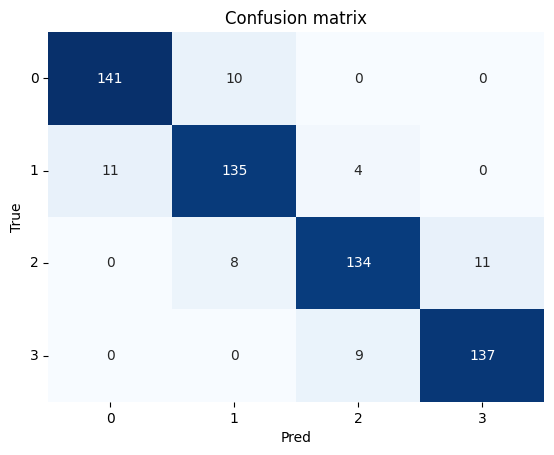

In [ ]:
'''
Confusion matrix (Мультиклассовый)
'''

classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
'''
построим график

'''

plt.show()

In [ ]:
'''
Вспомогательная функция для построения confusion matrix для каждого класса
'''
def compute_class(ls_res, class_value): # возвращаем строку имен классов
    y_t_class = ls_res.copy().astype(int)
    y_t_class = y_t_class.apply(lambda c: 1 if c  == class_value  else 0)
    return  y_t_class

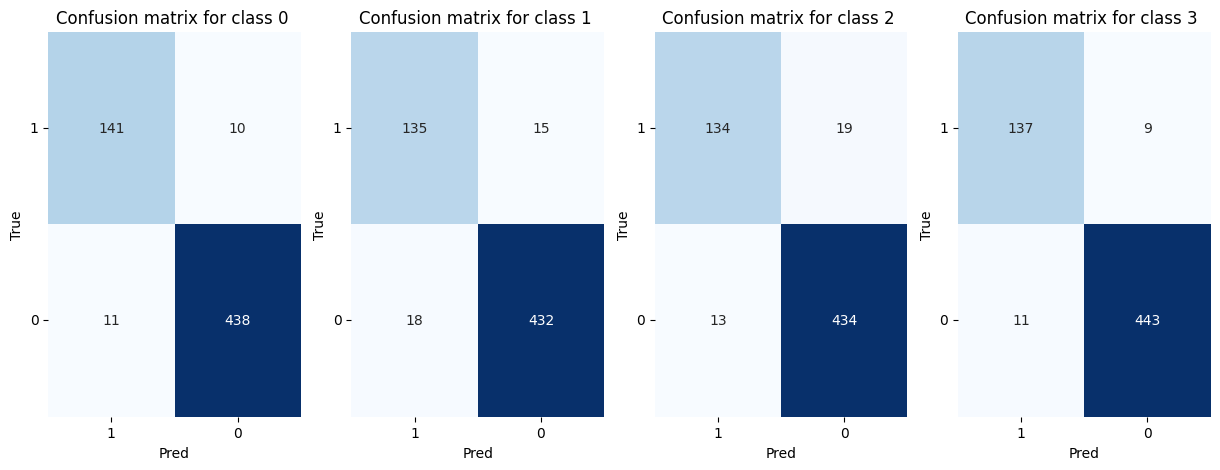

In [ ]:
'''
Confusion matrix (для каждого класса по отдельности)
'''

classes = np.unique(y_test).astype(int)
lbs = [1,0]
'''
plt.subplots()это функция, которая возвращает кортеж, содержащий фигуру и объект(ы) осей.
plt.subplots() возвращает кортеж с двумя элементами.
1-й должен быть объектом фигуры, а 2й должен быть группой объектов второстепенных сюжетов.

При использовании fig, ax = plt.subplots()вы распаковываете этот кортеж в переменные figи ,ax.

Наличие fig полезно, если вы хотите изменить атрибуты уровня фигуры или сохранить фигуру как файл изображения позже
(например, с помощью fig.savefig('yourfilename.png')).
plt.grid - Настройка линий сетки.

'''
fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(15,5),dpi=100)

for class_i in classes:
    y_one_class = compute_class(y_test,class_i)
    predicted_one_class = compute_class(pd.Series(predicted.tolist()),class_i)#возвращает строку имен классов
    cm = metrics.confusion_matrix(y_one_class, predicted_one_class, labels=lbs)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=ax[class_i])
    ax[class_i].set(xlabel="Pred", ylabel="True", title=f"Confusion matrix for class {class_i} ")
    ax[class_i].set_xticklabels(labels=lbs, rotation=0)
    ax[class_i].set_yticklabels(labels=lbs, rotation=0)

'''
построим график

'''
plt.show()

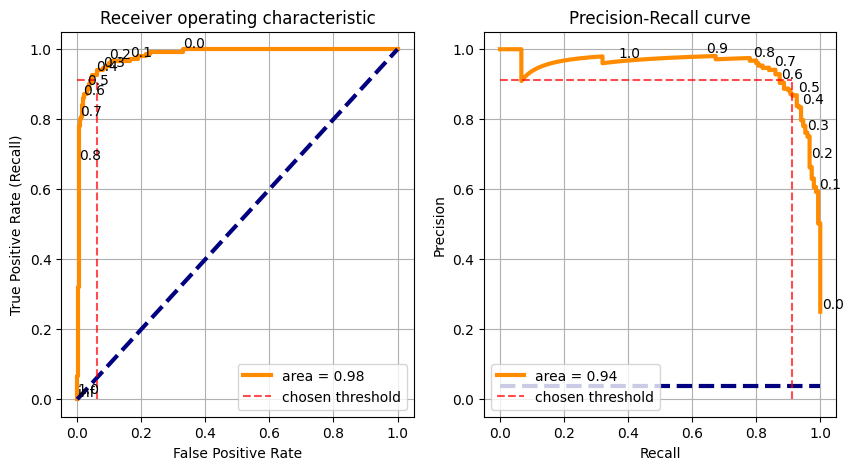

In [ ]:
'''
Еще ROC кривые
'''

classes = np.unique(y_test)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5),dpi=100)
'''

## plot ROC curve
построим кривую ROC

'''
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
ax[0].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].hlines(y=recall, xmin=0, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[0].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
ax[0].set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
## annotate ROC thresholds
'''
найдем пороговые значения ROC
'''

thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[0].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
## plot P-R curve
'''
плстроим привую P-R
'''

precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob[:,1], pos_label=1)
roc_auc = metrics.auc(recalls, precisions)
ax[1].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
ax[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
ax[1].set(xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)
## annotate P-R thresholds
'''
пороговые значения P-R
'''
thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[1].annotate(np.round(t,1), xy=(recalls[i],precisions[i]),
                    xytext=(recalls[i],precisions[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
plt.show()

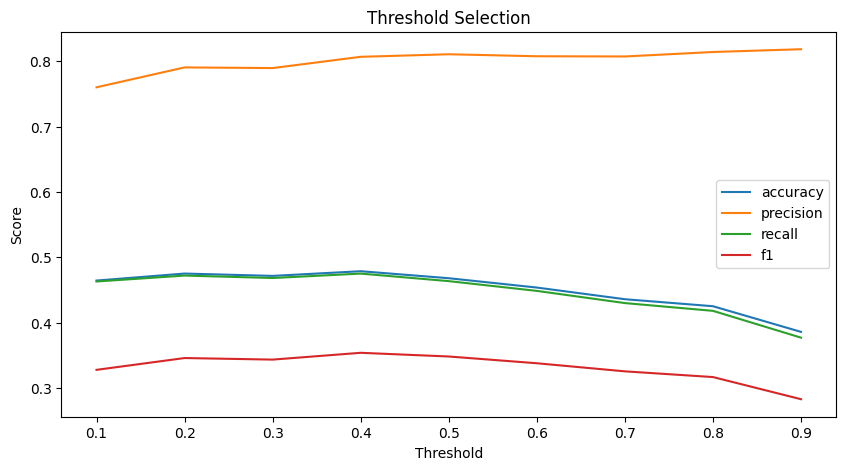

In [ ]:
## calculate scores for different thresholds
'''
Определим, какие значения отсечки лучше всего для нашей модели.
Для этого построим график ("значение отсечки", "значение метрики") для каждой метрики accuracy, precision, recall, f1
'''
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5),dpi=100)

dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]
thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(yy_test, predicted, average='macro', zero_division=1))
    dic_scores["recall"].append(metrics.recall_score(yy_test, predicted, average='macro'))
    dic_scores["f1"].append(metrics.f1_score(yy_test, predicted, average='macro'))
'''
Добавим линии
'''
## plot
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
ax.set(xlabel='Threshold', ylabel="Score", title="Threshold Selection")
dtf_scores.plot(ax=ax)
'''
отрисовываем
'''

plt.show()